# HybridBayesNet

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/hybrid/doc/HybridBayesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass  # Not running on Colab, do nothing

A `HybridBayesNet` represents a directed graphical model (Bayes Net) specifically designed for hybrid systems. It is a collection of `gtsam.HybridConditional` objects, ordered according to an elimination sequence.

It extends `gtsam.BayesNet<HybridConditional>` and allows representing the joint probability distribution $P(X, M)$ over continuous variables $X$ and discrete variables $M$ as a product of conditional probabilities:
$$
P(X, M) = \prod_i P(\text{Frontal}_i | \text{Parents}_i)
$$
where each conditional $P(\text{Frontal}_i | \text{Parents}_i)$ is stored as a `HybridConditional`. This structure allows for representing complex dependencies, such as continuous variables conditioned on discrete modes ($P(X|M)$) alongside purely discrete ($P(M)$) or purely continuous ($P(X)$) relationships.

`HybridBayesNet` objects are typically obtained by eliminating a `HybridGaussianFactorGraph`.

In [2]:
import gtsam
import numpy as np
import graphviz

from gtsam import (
    HybridConditional,
    GaussianConditional,
    DiscreteConditional,
    HybridGaussianConditional,
    HybridGaussianFactorGraph,
    HybridGaussianFactor,
    JacobianFactor,
    DecisionTreeFactor,
    Ordering,
)
from gtsam.symbol_shorthand import X, D

## Creating a HybridBayesNet

While they can be constructed manually by adding `HybridConditional`s, they are more commonly obtained via elimination of a `HybridGaussianFactorGraph`.

Manually Constructed HybridBayesNet:


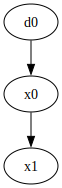

In [3]:
# --- Method 1: Manual Construction ---
hbn_manual = gtsam.HybridBayesNet()

# P(D0)
dk0 = (D(0), 2)
cond_d0 = DiscreteConditional(dk0, [], "7/3") # P(D0=0)=0.7
hbn_manual.push_back(HybridConditional(cond_d0))

# P(X0 | D0)
dk0_parent = (D(0), 2)
 # Mode 0: P(X0 | D0=0) = N(0, 1)
gc0 = GaussianConditional(X(0), np.zeros(1), np.eye(1), gtsam.noiseModel.Unit.Create(1))
 # Mode 1: P(X0 | D0=1) = N(5, 4)
gc1 = GaussianConditional(X(0), np.array([2.5]), np.eye(1)*0.5, gtsam.noiseModel.Isotropic.Sigma(1,2.0))
cond_x0_d0 = HybridGaussianConditional(dk0_parent, [gc0, gc1])
hbn_manual.push_back(HybridConditional(cond_x0_d0))

# P(X1 | X0)
cond_x1_x0 = GaussianConditional(X(1), np.array([0.0]), np.eye(1), # d, R=I
                             X(0), np.eye(1),                  # Parent X0, S=I
                             gtsam.noiseModel.Isotropic.Sigma(1, 1.0)) # N(X1; X0, I)
hbn_manual.push_back(HybridConditional(cond_x1_x0))

print("Manually Constructed HybridBayesNet:")
# hbn_manual.print()
graphviz.Source(hbn_manual.dot())


Original HybridGaussianFactorGraph for Elimination:


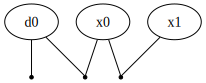

In [4]:
# --- Method 2: From Elimination ---
hgfg = HybridGaussianFactorGraph()
# P(D0) = 70/30
hgfg.push_back(DecisionTreeFactor([dk0], "0.7 0.3"))
# P(X0|D0) = mixture N(0,1); N(5,4)
# Factor version: 0.5*|X0-0|^2/1 + C0 ; 0.5*|X0-5|^2/4 + C1
factor_gf0 = JacobianFactor(X(0), np.eye(1), np.zeros(1), gtsam.noiseModel.Isotropic.Sigma(1, 1.0))
factor_gf1 = JacobianFactor(X(0), np.eye(1), np.array([5.0]), gtsam.noiseModel.Isotropic.Sigma(1, 2.0))
# Store -log(prior) for D0 in the hybrid factor (optional, could keep separate)
logP_D0_0 = -np.log(0.7)
logP_D0_1 = -np.log(0.3)
hgfg.push_back(HybridGaussianFactor(dk0, [(factor_gf0, logP_D0_0), (factor_gf1, logP_D0_1)]))
# P(X1|X0) = N(X0, 1)
hgfg.push_back(JacobianFactor(X(0), -np.eye(1), X(1), np.eye(1), np.zeros(1), gtsam.noiseModel.Isotropic.Sigma(1, 1.0)))

print("\nOriginal HybridGaussianFactorGraph for Elimination:")
# hgfg.print()
graphviz.Source(hgfg.dot())


HybridBayesNet from Elimination:


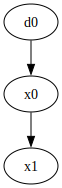

In [5]:
# Note: Using HybridOrdering(hgfg) is generally recommended: 
# it returns a Colamd constrained ordering where the discrete keys are
# eliminated after the continuous keys.
ordering = gtsam.HybridOrdering(hgfg)

hbn_elim, _ = hgfg.eliminatePartialSequential(ordering)
print("\nHybridBayesNet from Elimination:")
# hbn_elim.print()
graphviz.Source(hbn_elim.dot())

## Operations on HybridBayesNet

`HybridBayesNet` allows evaluating the joint probability, sampling, optimizing (finding the MAP state), and extracting marginal or conditional distributions.

In [6]:
# Use the Bayes Net from elimination for consistency
hbn = hbn_elim

# --- Evaluation ---
values = gtsam.HybridValues()
values.insert(D(0), 0)
values.insert(X(0), np.array([0.1]))
values.insert(X(1), np.array([0.2]))

log_prob = hbn.logProbability(values)
prob = hbn.evaluate(values) # Same as exp(log_prob)
print(f"\nLogProbability P(X0=0.1, X1=0.2, D0=0): {log_prob}")
print(f"Probability P(X0=0.1, X1=0.2, D0=0): {prob}")

# --- Sampling ---
full_sample = hbn.sample()
print("\nSampled HybridValues:")
full_sample.print()

# --- Optimization (Finding MAP state) ---
# Computes MPE for discrete, then optimizes continuous given MPE
map_solution = hbn.optimize()
print("\nMAP Solution (Optimize):")
map_solution.print()

# --- MPE (Most Probable Explanation for Discrete Variables) ---
mpe_assignment = hbn.mpe()
print("\nMPE Discrete Assignment:")
print(mpe_assignment) # Should match discrete part of map_solution


LogProbability P(X0=0.1, X1=0.2, D0=0): -2.160749387689685
Probability P(X0=0.1, X1=0.2, D0=0): 0.11523873018620859

Sampled HybridValues:
HybridValues: 
  Continuous: 2 elements
  x0: 6.29382
  x1: 6.6918
  Discrete: (d0, 1)
  Nonlinear
Values with 0 values:

MAP Solution (Optimize):
HybridValues: 
  Continuous: 2 elements
  x0: 0
  x1: 0
  Discrete: (d0, 0)
  Nonlinear
Values with 0 values:

MPE Discrete Assignment:
DiscreteValues{7205759403792793600: 0}


In [7]:
# --- Optimize Continuous given specific Discrete Assignment ---
dv = gtsam.DiscreteValues()
dv[D(0)] = 1
cont_solution_d0_eq_1 = hbn.optimize(dv)
print("\nOptimized Continuous Solution for D0=1:")
cont_solution_d0_eq_1.print()



Optimized Continuous Solution for D0=1:
VectorValues: 2 elements
  x0: 5
  x1: 5


In [8]:
# --- Extract Marginal/Conditional Distributions ---
# Get P(M) = P(D0)
discrete_marginal_bn = hbn.discreteMarginal()
print("\nDiscrete Marginal P(M):")
discrete_marginal_bn.print()

# Get P(X | M=m) = P(X0, X1 | D0=0)
dv[D(0)] = 0
gaussian_conditional_bn = hbn.choose(dv)
print("\nGaussian Conditional P(X | D0=0):")
gaussian_conditional_bn.print()


Discrete Marginal P(M):
DiscreteBayesNet
 
size: 1
conditional 0:  P( d0 ):
 f[ (d0,2), ]
(d0, 0) | 0.731343   | 0
(d0, 1) | 0.268657   | 1
number of nnzs: 2


Gaussian Conditional P(X | D0=0):

size: 2
conditional 0:  p(x1 | x0)
  R = [ 1 ]
  S[x0] = [ -1 ]
  d = [ 0 ]
  logNormalizationConstant: -0.918939
  No noise model
conditional 1:  p(x0)
  R = [ 1 ]
  d = [ 0 ]
  mean: 1 elements
  x0: 0
  logNormalizationConstant: -0.918939
  No noise model


## Advanced Operations (`errorTree`, `discretePosterior`, `prune`)

In [9]:
# --- Error Tree (Log P'(M|x) = log P(x|M) + log P(M)) ---
# Evaluate unnormalized log posterior of discrete modes given continuous values
cont_values_for_error = gtsam.VectorValues()
cont_values_for_error.insert(X(0), np.array([0.5]))
cont_values_for_error.insert(X(1), np.array([1.0]))

error_tree = hbn.errorTree(cont_values_for_error)
print("\nError Tree (Unnormalized Log Posterior Log P'(M|x)) for x0=0.5, x1=1.0:")
error_tree.print()

# --- Discrete Posterior P(M|x) ---
# Normalized version of exp(-errorTree)
posterior_tree = hbn.discretePosterior(cont_values_for_error)
print("\nDiscrete Posterior Tree P(M|x) for x0=0.5, x1=1.0:")
posterior_tree.print()


Error Tree (Unnormalized Log Posterior Log P'(M|x)) for x0=0.5, x1=1.0:
AlgebraicDecisionTreeKey
 Choice(d0) 
AlgebraicDecisionTreeKey
 0 Leaf 0.56287232
AlgebraicDecisionTreeKey
 1 Leaf 4.663718

Discrete Posterior Tree P(M|x) for x0=0.5, x1=1.0:
AlgebraicDecisionTreeKey
 Choice(d0) 
AlgebraicDecisionTreeKey
 0 Leaf 0.98371106
AlgebraicDecisionTreeKey
 1 Leaf 0.016288942



Pruned HybridBayesNet (max_leaves=1):
HybridBayesNet
 
size: 2
conditional 0: p(x1 | x0)
  R = [ 1 ]
  S[x0] = [ -1 ]
  d = [ 0 ]
  logNormalizationConstant: -0.918939
  No noise model
conditional 1: p(x0)
  R = [ 1 ]
  d = [ 0 ]
  mean: 1 elements
  x0: 0
  logNormalizationConstant: -0.918939
  No noise model


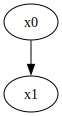

In [10]:
# --- Pruning ---
# Reduces complexity by removing low-probability discrete branches
max_leaves = 1 # Force pruning to the most likely mode
pruned_hbn = hbn.prune(max_leaves, marginalThreshold=0.8)

print(f"\nPruned HybridBayesNet (max_leaves={max_leaves}):")
pruned_hbn.print()
# Visualize the pruned Bayes Net
graphviz.Source(pruned_hbn.dot())